In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import json
from graphframes import GraphFrame

sys.path.append("glue_py_resources")

from utility_functions import *
from sql_steps import *
from pipelines import get_features_df
from rules import *
from accuracy import *

In [3]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf=SparkConf()
conf.set('spark.driver.extraClassPath','./graphframes-0.7.0-spark2.3-s_2.11.jar')
conf.set('spark.driver.memory', '8g')
conf.set("spark.sql.shuffle.partitions", "1") 

sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)
spark.sparkContext.setCheckpointDir('/tmp/spark_temp/')

## Overall approach

We want to deduplicate a dataset, `df`.

At a high level we want to create pairs of records for comparison - e.g. compare record id 1 with record id 2, and determine whether it's a match (i.e. the records represent the same entity).  These records then start to form groups of records - e.g. if 1 matches to 2, and 2 to 3, we now have a group of records (1,2,3).

How do we 'measure' whether a given pair of records is really a match?  We need to compute some 'features' (i.e. 'indepdendent variables', or 'scores') which we can use to predict whether a record is a a match or not.

So the approach will be to:
- Use blocking rules to generate potential matches.  These rules should ideally have a recall (sensitivity) of 1  (i.e. they identify 100% of records which really are matches), but potentially low precision (i.e. they may also capture a lot of records which aren't really matches).
- Use various approaches like probablistic scoring and string comparison to create numeric features
- Use a stats/ML model to train a model to generate predictions from these features
- Compute the accuracy of this model from a 'ground truth' dataset.


*Note*  The following steps are laid out in sequence in commented SQL statements in the `sql_steps.py` file

## Step 1:  Clean and normalise data, choose columns for dedupe

There's a variety of things we could do here like correcting misspellings, normalising name aliases etc Robbie = Robert or whatever.

In this simple example I don't do any cleaning and normalisation

## Step 2: Set up train, test split  



In [4]:
df = spark.read.parquet("fake_1000.parquet")
df = df.dropDuplicates()

group_max = df.select([f.max("group")]).collect()[0][0]  # Since records are in labelled groups, we don't want to just randomly create a training test split.  Instead take half the groups
group_cutoff = int(group_max/2)

df = sql_add_unique_row_id_to_original_table(df, spark)
df.show(5)

+----------+-------+----------+---------+-------------------+-----+------------+
|first_name|surname|       dob|     city|              email|group|      row_id|
+----------+-------+----------+---------+-------------------+-----+------------+
|      null|  Murya|1975-03-13|   London|sgraham@chapman.com|    0|4369c0ae2ecc|
|     Luna | Murray|1975-03-13|   London| sghaham@crapmn.com|    0|b4fd48f9fec7|
|     Luna | Murray|1975-03-13|     null| sgraham@chapm.naom|    0|1d5e937cd037|
|     Luna | Murray|1975-03-13|   London|sgraham@chapman.com|    0|82c98ced2d2e|
|       Ka | Arnold|1971-01-10|Leicester|brownkelly@hill.com|    1|7fdfead6a6e3|
+----------+-------+----------+---------+-------------------+-----+------------+
only showing top 5 rows



## Step 3: Split out tokens

Tokens be used for computing match probabilities

In [5]:
train = df.filter(df.group < group_cutoff )
test = df.filter(df.group >= group_cutoff )
cols = ["first_name", "surname", "dob", "city", "email"]
train = sql_concat_cols(train, spark, cols)
train = tokenise_concat_field(train, spark)
train.sort('row_id').show(5)

+----------+-------+----------+--------+--------------------+-----+------------+--------------------+--------------------+
|first_name|surname|       dob|    city|               email|group|      row_id|              concat|              tokens|
+----------+-------+----------+--------+--------------------+-----+------------+--------------------+--------------------+
|   Harley |  Jones|1975-12-03|Brighton|jefreyfowler@reev...|   39|005185ac66b7|Harley  Jones 197...|[harley, jones, 1...|
|     rturA|  Smith|1992-11-08|  London|elizabeth04@russo...|   20|009f27d355a5| rturA Smith 1992...|[rtura, smith, 19...|
|  William |Collins|1979-05-19|    null|jermaine18@wright...|   60|011089d9f8ab|William  Collins ...|[william, collins...|
|      Webb|  Jack |2007-07-13|    null|frankpierce@demin...|   58|030449a15e6c|Webb Jack  2007-0...|[webb, jack, 2007...|
|     Theo | Taylor|1995-11-28|    null|larrygutierrez@es...|   76|03ec87815aed|Theo  Taylor 1995...|[theo, taylor, 19...|
+----------+----

### Step 3 Comments/Potential improvements/Other approaches

In reality it will probably be better to tokenise columns individually or in thematic groups - e.g. first name and surname, rather than concat eveything

Some tokens shouldn't be split - e.g. `stockton-on-tees` is not really three independent tokens, it is more comparible (in its information content) to `london`

## Step 4: Get probability lookup

Get a lookup table that contains the relative frequency of appearance of each token

In [6]:
prob_lookup_train = get_token_probabilities_lookup(train, spark)
prob_lookup_train.sort(f.desc('prob')).show(5)

+------+--------------------+
| token|                prob|
+------+--------------------+
|   com| 0.05490097768864377|
|london|0.030584106292303837|
|    10|0.018049636500376033|
|    11|0.017548257708698924|
|    01|0.015292053146151919|
+------+--------------------+
only showing top 5 rows



## Step 5:  Apply blocking rules

This is a sql statement like:

```
select blah
from
    (
        select blah
        from df as l
            left join df as r on l.first_name = r.first_name and l.surname = r.surname
        where l.row_id < r.row_id
        
    union
        
        select blah
        from df as l
            left join df as r on l.first_name = r.first_name and l.email = r.email
        where
            l.row_id < r.row_id
    )
```

followed by a dropDuplicates on `row_id_l", "row_id_r"`

See `rules.py` for a list of the rules we're using.  

These rules should ideally have a recall (sensitivity) of 1 (i.e. they identify 100% of records which really are matches), but potentially low precision (i.e. they may also capture a lot of records which aren't really matches).  Later we'll see that they don't actually have a recall of one, resulting in some false negatives.

In [7]:
rules = get_test_data_rules()
potential_matches_train = get_potential_matches(train, spark, rules)
potential_matches_train.sort("row_id_l", "row_id_r").show(5)

+------------+------------+--------------------+--------------------+--------------------+
|    row_id_l|    row_id_r|            tokens_l|            tokens_r|            match_id|
+------------+------------+--------------------+--------------------+--------------------+
|005185ac66b7|41076c39001d|[harley, jones, 1...|[harley, jnos, 19...|005185ac66b7_4107...|
|005185ac66b7|72496bac94a0|[harley, jones, 1...|[harley, jones, 1...|005185ac66b7_7249...|
|005185ac66b7|8f25bf76e7c2|[harley, jones, 1...|[harley, jones, 1...|005185ac66b7_8f25...|
|005185ac66b7|fe2cea1b0144|[harley, jones, 1...|[jones, 1975, 12,...|005185ac66b7_fe2c...|
|009f27d355a5|312b3380b44d|[rtura, smith, 19...|[smith, 2018, 10,...|009f27d355a5_312b...|
+------------+------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Step 5 Comments/Potential improvements/Other approaches

I think this step is a key area where there's room for improvement:
- Is it possible to apply the blocking rules using a sort and then a window function, then a graph algo like connected components rather than having to perform loads of joins?  This could e.g. prevent one large block having to be executed on a single executor?
- Is it possible to somehow limit group sizes so none of the groups are 'allowed' to explode.  A key pain point is that we have to wait for the largest block for this sql to complete.
- What's the performance of the union and then drop duplicates?  Is there a way of doing this that doesn't require a shuffle?

## Step 6:  Compare matches to compute features

### Step 6a:  Find matching tokens

We need a way of comparing `tokens_l` to `tokens_r`, to find matching tokens.  For matching tokens, we then want to look up their probabilities in `prob_lookup`

We could write a python UDF for this that worked on `potential matches`.  To do it in SQL, I explode the tokens into a cartesian product:

In [8]:
word_combinations_train = get_word_combinations(potential_matches_train, spark)
# print(word_combinations.count())  #This will be a big dataframe!!
word_combinations_train.sort("row_id_l", "row_id_r").show(5)

+-------+-------+------------+--------------------+-------+-------+------------+--------------------+
|index_l|token_l|    row_id_l|          match_id_l|index_r|token_r|    row_id_r|          match_id_r|
+-------+-------+------------+--------------------+-------+-------+------------+--------------------+
|      0| harley|005185ac66b7|005185ac66b7_4107...|      0| harley|41076c39001d|005185ac66b7_4107...|
|      0| harley|005185ac66b7|005185ac66b7_4107...|      1|   jnos|41076c39001d|005185ac66b7_4107...|
|      0| harley|005185ac66b7|005185ac66b7_4107...|      2|   1975|41076c39001d|005185ac66b7_4107...|
|      0| harley|005185ac66b7|005185ac66b7_4107...|      3|     12|41076c39001d|005185ac66b7_4107...|
|      0| harley|005185ac66b7|005185ac66b7_4107...|      4|     03|41076c39001d|005185ac66b7_4107...|
+-------+-------+------------+--------------------+-------+-------+------------+--------------------+
only showing top 5 rows



In [9]:
matching_tokens_train = find_exact_and_fuzzy_matching_tokens(word_combinations_train, spark)
matching_tokens_train = matching_tokens_with_prob(matching_tokens_train, prob_lookup_train, spark)
matching_tokens_train.sort("row_id_l", "row_id_r").show(5)
matching_tokens_train.filter(matching_tokens_train.exact_match == False).sort("row_id_l", "row_id_r").show(5)

+-----------+-------+------------+-------+------------+-------------------+
|exact_match|token_l|    row_id_l|token_r|    row_id_r|           log_prob|
+-----------+-------+------------+-------+------------+-------------------+
|       true| harley|005185ac66b7| harley|41076c39001d| -6.681857939471306|
|      false|  jones|005185ac66b7|   jnos|41076c39001d| -2.826119261145074|
|       true|   1975|005185ac66b7|   1975|41076c39001d| -5.988710758911361|
|       true|     12|005185ac66b7|     12|41076c39001d|-4.4626544554163114|
|       true|     03|005185ac66b7|     03|41076c39001d| -4.248244584070856|
+-----------+-------+------------+-------+------------+-------------------+
only showing top 5 rows

+-----------+------------+------------+-------------+------------+-------------------+
|exact_match|     token_l|    row_id_l|      token_r|    row_id_r|           log_prob|
+-----------+------------+------------+-------------+------------+-------------------+
|      false|jefreyfowler|0051

In [10]:
matching_records_train = reduce_probability_tokens_to_records(matching_tokens_train, spark)
matching_records_train.sort("row_id_l", "row_id_r").show(5)

+------------+------------+----------+
|    row_id_l|    row_id_r|match_prob|
+------------+------------+----------+
|005185ac66b7|41076c39001d| -47.34102|
|005185ac66b7|72496bac94a0|-50.167137|
|005185ac66b7|8f25bf76e7c2|-41.456238|
|009f27d355a5|446814ea12e5| -8.559695|
|009f27d355a5|467f195af8e1|-13.759949|
+------------+------------+----------+
only showing top 5 rows



### Step 6 Comments/Potential improvements/Other approaches

- Is it right to reduce the datasets down to essential columns for these calculations then re-join records onto the final `row_id_l|row_id_r|match_prob` dataset?  (We could instead retain all fields and avoid this final join)

- These explode steps may be very expensive because you end up with an extremely large dataset which must be joined to the probability lookup
    - Could we broadcast join the probability lookup? It's big, but you could eliminate all tokens with e.g. count 1 from the lookup and use a 'default' value 
    - Could we instead pre-generate an indexed sqlite dataset of token probabilities and put this somewhere in s3, and use this for probability lookups?


### Step 6b.  Also get edit distance based metric

Currently this is just `levenshtein(l.concat, r.concat) as edit_distance,`

In [11]:
features_train= get_feature_vectors(train, matching_records_train, spark)
features_train.sort("row_id_l", "row_id_r").show(5, False)

+----------+-------------+----------+------------+------------+-------------------------+
|match_prob|edit_distance|real_group|row_id_l    |row_id_r    |features                 |
+----------+-------------+----------+------------+------------+-------------------------+
|-47.34102 |5            |1         |005185ac66b7|41076c39001d|[-47.34101867675781,5.0] |
|-50.167137|3            |1         |005185ac66b7|72496bac94a0|[-50.167137145996094,3.0]|
|-41.456238|7            |1         |005185ac66b7|8f25bf76e7c2|[-41.45623779296875,7.0] |
|-8.559695 |36           |0         |009f27d355a5|446814ea12e5|[-8.55969524383545,36.0] |
|-13.759949|10           |1         |009f27d355a5|467f195af8e1|[-13.75994873046875,10.0]|
+----------+-------------+----------+------------+------------+-------------------------+
only showing top 5 rows



## Step 7:  Fit logit

**Warning**  This logit is NOT being fitted on the full dataset, which would be the n(n-1)/2 - sized table of all comparisons.

This means the metrics like the ROC curve calculated from the regression model have to be interpreted with care

**Note** I set threshold to 0.9 to reflect our preference for false negatives over false positives

In [12]:
lr = LogisticRegression(maxIter=10,regParam=0.01,threshold=0.9,featuresCol="features",labelCol="real_group")
lr_model = lr.fit(features_train)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.09384102169457409,-0.12444747097658133]
Intercept: 3.3734241764379975


Here's the ROC curve on **training** data, i.e watch out for overfitting

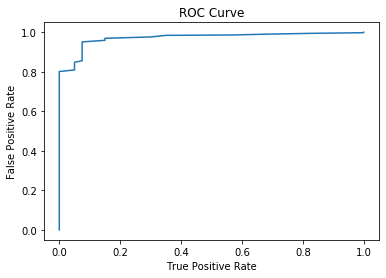

In [13]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
lr_summary = lr_model.summary

roc = lr_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## Step 8:  Apply model to test data

We then apply the same sequence of steps to the test data to translate it into features
We then apply the logit model toget predictions.

Note that doing ROC analysis is quite tricky because it requires repeatedly running the connected components algorithm

In [14]:
# test_features = get_features_df(test, spark)  # NOTE - if you don't need to inspect what's going on, this runs the full pipeline 
test = df.filter(df.group >= group_cutoff )
cols = ["first_name", "surname", "dob", "city", "email"]
test = sql_concat_cols(test, spark, cols)
test = tokenise_concat_field(test, spark)
prob_lookup_test = get_token_probabilities_lookup(test, spark)
rules = get_test_data_rules()
potential_matches_test = get_potential_matches(test, spark, rules)

word_combinations_test = get_word_combinations(potential_matches_test, spark)
matching_tokens_test = find_exact_and_fuzzy_matching_tokens(word_combinations_test, spark)
matching_tokens_test = matching_tokens_with_prob(matching_tokens_test, prob_lookup_test, spark)
matching_records_test = reduce_probability_tokens_to_records(matching_tokens_test, spark)
features_test = get_feature_vectors(test, matching_records_test, spark)

predictions = lr_model.transform(features_test)
predictions.sort("row_id_l", "row_id_r").show(5, True)
# Note getting prob as float is difficult. you can do preds = predictions.select('real_group','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['real_group'])))




+----------+-------------+----------+------------+------------+--------------------+--------------------+--------------------+----------+
|match_prob|edit_distance|real_group|    row_id_l|    row_id_r|            features|       rawPrediction|         probability|prediction|
+----------+-------------+----------+------------+------------+--------------------+--------------------+--------------------+----------+
|-27.986177|           26|         1|000a6db69cc5|2d3cbb76c46b|[-27.986177444458...|[-2.7640414157604...|[0.05929852494575...|       1.0|
| -37.63982|           21|         1|000a6db69cc5|83a2a855e7e7|[-37.639820098876...|[-4.2921864604083...|[0.01349051012761...|       1.0|
|-31.595865|           24|         1|000a6db69cc5|efab28dc90fb|[-31.595865249633...|[-3.3516731493497...|[0.03384041744644...|       1.0|
|-40.312283|            6|         1|00c4089abe95|5d1fccd3b374|[-40.312282562255...|[-6.4096851330609...|[0.00164283918567...|       1.0|
| -9.615419|           33|        

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="real_group")
print(evaluator.evaluate(predictions))


0.9817514901421368


## Step 9: Use connected component to recover groups 

In [16]:
#  Need a dataset of edges and nodes

test_nodes = test.withColumnRenamed("row_id", "id")
test_edges = predictions.withColumnRenamed("row_id_l", "src").withColumnRenamed("row_id_r", "dst").filter(predictions.prediction == 1.0)

g = GraphFrame(test_nodes, test_edges)

In [17]:
cc = g.connectedComponents()
cc.cache()
cc.sort("id").show(5)

+----------+--------+----------+------+--------------------+-----+------------+--------------------+--------------------+---------+
|first_name| surname|       dob|  city|               email|group|          id|              concat|              tokens|component|
+----------+--------+----------+------+--------------------+-----+------------+--------------------+--------------------+---------+
|   Arthur |    Wood|1983-08-03|  null|chriotinaroberon@...|  116|000a6db69cc5|Arthur  Wood 1983...|[arthur, wood, 19...|        0|
|     Lexi |Thompson|1971-04-04|London|nbrewer@jones-bro...|  123|00c4089abe95|Lexi  Thompson 19...|[lexi, thompson, ...|        1|
|   Phoebe |    Adas|1998-02-24|London|tracydavis@frank-...|  174|014006800ddd|Phoebe  Adas 1998...|[phoebe, adas, 19...|        2|
|      null|  Hudson|1981-01-19|London| joannahowe@todd.com|  180|01a747dab0f7| Hudson 1981-01-1...|[hudson, 1981, 01...|        3|
|  Jessica |Ferguson|2005-10-28|London|    rbrady@wolfe.org|  135|01c777d28e

## Step 10: Compute accuracy statistics 


In [18]:
import json
pairs = get_real_pred_pairs(cc, spark, id_col="id")
print(json.dumps(get_accuracy_statistics(pairs, cc, spark), indent=4))

{
    "total_pairs": 91806,
    "true_positive_count": 922,
    "true_negative_count": 90757,
    "false_positive_count": 0,
    "false_negative_count": 127,
    "sensitivity": 0.8789323164918971,
    "precision": 1.0
}


In [19]:
pairs.show(5)

+-------+-------+-----------+-----------+------------+------------+-----------------------+--------------------------+--------------+
|group_l|group_r|component_l|component_r|        id_l|        id_r|is_part_of_actual_group|is_estimated_as_same_group|accuracy_class|
+-------+-------+-----------+-----------+------------+------------+-----------------------+--------------------------+--------------+
|     90|     90|         58|         58|2590ed6dd36d|c5a5c584600e|                   true|                      true|            tp|
|     90|     90|         58|         58|2590ed6dd36d|da969951beea|                   true|                      true|            tp|
|     90|     90|         58|         58|2590ed6dd36d|47552351c41a|                   true|                      true|            tp|
|     90|     90|         58|         58|47552351c41a|c5a5c584600e|                   true|                      true|            tp|
|     90|     90|         58|         58|47552351c41a|da969951

## Step 11: View some false positives and false negatives

Note not all comparisons have a `match_prob`.

The reason is that if our cc say:
A matches to B because computed prob is x
and B matches to C because computed prob is x

That doesn't mean we have the score for A to C.

In [32]:
def get_sample_fp(pairs, orig_data, predictions, spark):

    pairs.registerTempTable('pairs')
    orig_data.registerTempTable('orig_data')
    predictions.registerTempTable('predictions')
    
    sql = f"""
    select {sql_gen_col_selection_compare_cols(orig_data)}, accuracy_class, match_prob, edit_distance, component_l, component_r
    from pairs as p

    inner join orig_data as l
    on l.row_id = p.id_l
    inner join orig_data as r
    on r.row_id = p.id_r
    
    
    inner join predictions as pred
    on r.row_id = pred.row_id_r
    and l.row_id = pred.row_id_l
    

    where accuracy_class = 'fn'
    
    """

    return spark.sql(sql)

get_sample_fp(pairs, test, predictions, spark).toPandas().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_name_l,Henry,None,Wright,None,Jones,Harrison,Henry,Henry,Elizabeth,Elizabeth,Elizabeth,Elizabeth,Wright,Evans,Oavil,Elizabeth,Evans,None,Wright
first_name_r,Wright,Ch lesa,Henry,Jones,Willow,Perry,Hen y,Hen y,Elizabeth,Elizabeth,Elizabeth,Elizabeth,Henry,Evans,Olivia,Elizabeth,Evans,aDsy,Henry
surname_l,Wright,Booth,Henry,Jons,Willow,Perry,Wright,Wright,Htn,Hunt,Hut,Htn,Henry,William,Gordon,None,William,Stevens,Henry
surname_r,Henry,Booth,Wright,Willow,Jones,Harrison,Wright,Wright,None,None,None,None,Wright,William,Gordon,Hunt,William,Stevens,Wright
dob_l,2015-07-12,1993-07-27,2015-07-12,1992-12-02,1992-12-02,2012-12-24,2015-07-12,2015-07-12,1973-02-07,1973-02-07,1973-02-07,1973-02-07,2015-07-12,1997-02-11,2004-12-17,1973-02-07,1997-02-14,1987-11-07,2015-07-12
dob_r,2015-07-12,1993-07-27,2015-07-12,1992-12-02,1992-12-02,2012-12-24,2015-07-12,2015-07-12,1973-02-07,1973-02-07,1973-02-07,1973-02-07,2015-07-12,1997-02-14,2004-10-08,1973-02-07,1997-02-11,1987-11-07,2015-07-12
city_l,Leicester,Bristol,Leicester,Brighton,Brighton,Leeds,Leicester,Leicester,Brstol,rBstol,Bristol,Bristol,Leicester,London,Mansfield,None,London,None,Leicester
city_r,Leicester,Bristol,Leicester,Brighton,Brighton,Leeds,Lecester,Lecester,None,None,None,None,Leicester,London,Mansfield,Bristol,None,Lonon,Leicester
email_l,johnmorales@gibson-fernafdez.ino,evanvasquez@hudson-curry.com,None,albert66@butler.com,None,bobby32@saunders.net,johnmorales@gibson-fernafdez.ino,johmoralesbgi@son-fernandez.info,donna35@gonzalez.com,donna35@gonzalez.com,donna35@gonzalez.com,donna35@gnzalez.com,None,ashleypowell@kemp-nguyen.net,None,None,None,None,None
email_r,None,None,johmoralesbgi@son-fernandez.info,None,albert66@butler.com,None,None,None,None,None,None,None,johnmorales@gibson-fernandez.info,None,jeffreyshah@cherry.info,donna35@gonzalez.com,ashleypowell@kemp-nguyen.net,craigwerner@smith-lynch.com,johnmorales@gdbson-fernanez.info


## Annex:  Evaluate the blocking rules

It seems that most of our false negatives were the result of blocking rules missing them, rather than incorrect classification



In [31]:
def get_count_fn(pairs, orig_data, predictions, spark):

    pairs.registerTempTable('pairs')
    orig_data.registerTempTable('orig_data')
    predictions.registerTempTable('predictions')
    
    sql = f"""
    select count(*)
    from pairs as p

    inner join orig_data as l
    on l.row_id = p.id_l
    inner join orig_data as r
    on r.row_id = p.id_r

    left join predictions as pred
    on r.row_id = pred.row_id_r
    and l.row_id = pred.row_id_l

    where accuracy_class = 'fn'
    and match_prob is null
    
    union
    
    select count(*)
    from pairs as p

    inner join orig_data as l
    on l.row_id = p.id_l
    inner join orig_data as r
    on r.row_id = p.id_r

    left join predictions as pred
    on r.row_id = pred.row_id_r
    and l.row_id = pred.row_id_l

    where accuracy_class = 'fn'
    and match_prob is not null   
    
    """

    return spark.sql(sql)

get_count_fn(pairs, test, predictions, spark).toPandas().T

,0,1
count(1),108,19
